In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-07-25 18:01:43.577115: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 18:01:43.586150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753477303.596081   37017 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753477303.599395   37017 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753477303.607578   37017 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8890788630079519385
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10308222976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13622868012593066149
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1753477304.810428   37017 gpu_device.cc:2019] Created device /device:GPU:0 with 9830 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
import numpy as np

# Define color to class mapping
COLOR_MAP = {
    (0, 0, 0): 0,           # background
    (255, 0, 124): 1,       # oil
    (255, 204, 51): 2,      # others
    (51, 221, 255): 3       # water
}

def rgb_to_class(mask):
    """
    Convert RGB mask to single channel with class indices.
    mask: uint8 numpy array (H,W,3)
    returns: (H,W) int array with class ids
    """
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)

    for rgb, cls in COLOR_MAP.items():
        matches = np.all(mask == rgb, axis=-1)
        class_mask[matches] = cls
    return class_mask


In [3]:
import tensorflow as tf
import os

# tf.debugging.set_log_device_placement(True)

IMG_SIZE = (256, 256)

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)  # assuming PNG images, adapt if needed
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0,1]
    return img

def preprocess_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # masks are RGB
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    
    # Convert to numpy to do color mapping
    mask_np = tf.numpy_function(rgb_to_class, [mask], tf.uint8)
    mask_np.set_shape(IMG_SIZE + ())

    # One-hot encode for 4 classes
    mask_one_hot = tf.one_hot(mask_np, 4)
    return mask_one_hot

def load_image_mask(img_path, mask_path):
    return preprocess_image(img_path), preprocess_mask(mask_path)

def create_dataset(image_dir, mask_dir, batch_size=8, shuffle=True):
    img_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((img_files, mask_files))
    if shuffle:
        dataset = dataset.shuffle(len(img_files))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
# import segmentation_models as sm

def simple_unet_multi(input_shape=(256, 256, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    # Bottleneck
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    b = layers.Conv2D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u3 = layers.UpSampling2D(2)(b)
    concat3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat3)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D(2)(c4)
    concat2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat2)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    u1 = layers.UpSampling2D(2)(c5)
    concat1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat1)
    c6 = layers.Conv2D(16, 3, activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c6)

    model = tf.keras.Model(inputs, outputs)
    return model

model = simple_unet_multi()

# model = sm.Unet('resnet34', encoder_weights='imagenet', classes=4, activation='softmax')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


I0000 00:00:1753477330.961665   37017 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9830 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
import os

train_img_dir = os.path.expanduser('~/data/dataset/train/images')
train_mask_dir = os.path.expanduser('~/data/dataset/train/masks')

val_img_dir = os.path.expanduser('~/data/dataset/val/images')
val_mask_dir = os.path.expanduser('~/data/dataset/val/masks')

train_ds = create_dataset(train_img_dir, train_mask_dir)
val_ds = create_dataset(val_img_dir, val_mask_dir, shuffle=False)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

checkpoint = ModelCheckpoint("checkpoint_model.keras", save_best_only=True)

model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[checkpoint])

In [6]:
model = tf.keras.models.load_model('./models/original_images.keras')
model.summary()

/home/vinicius/Desktop/cubesat/ManchaSat/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_9[0][0]  

 Total params: 974,698 (3.72 MB)

 Trainable params: 487,348 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 487,350 (1.86 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


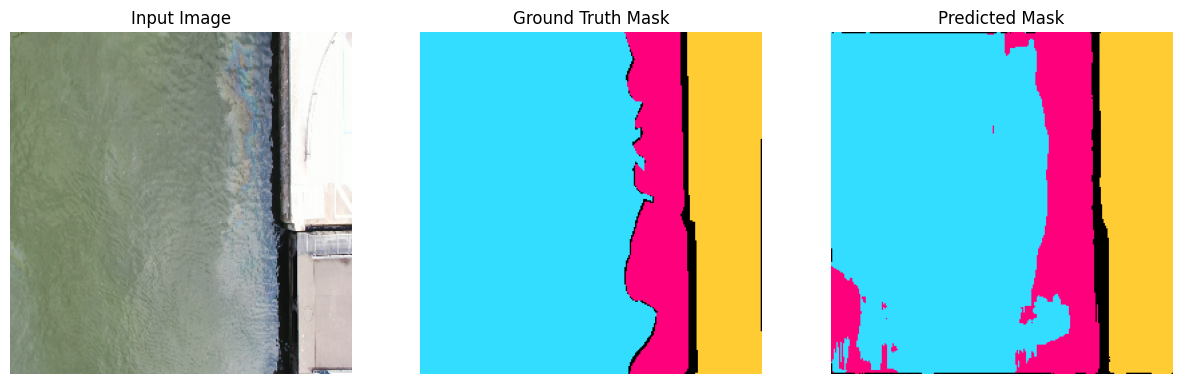

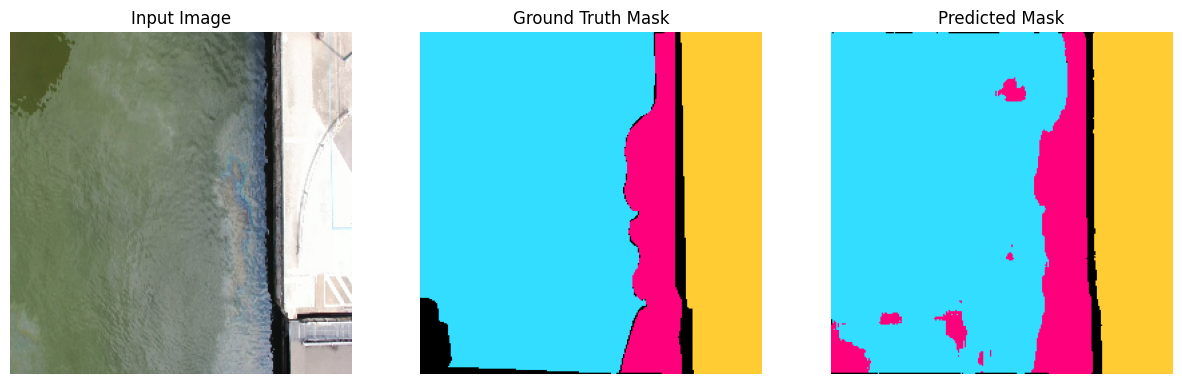

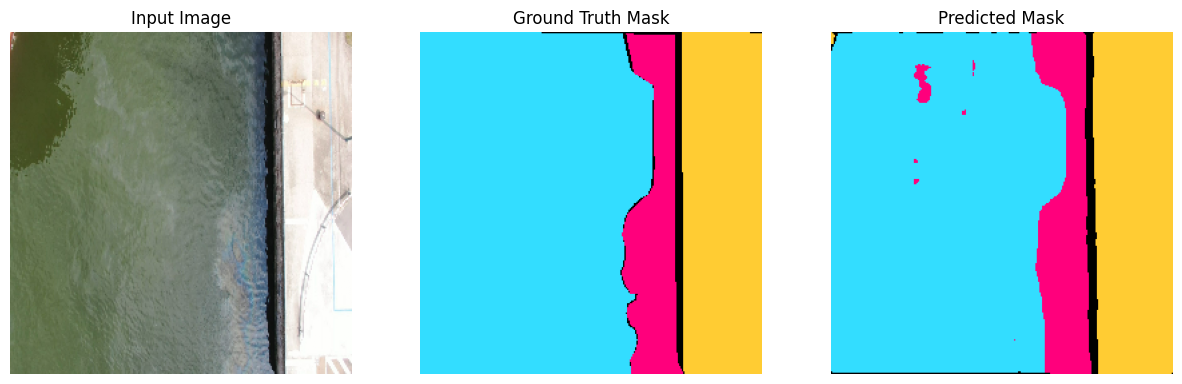

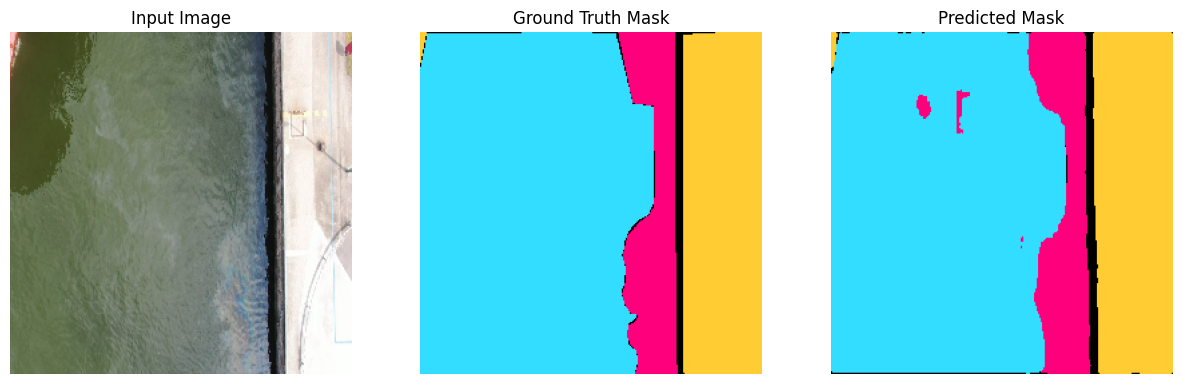

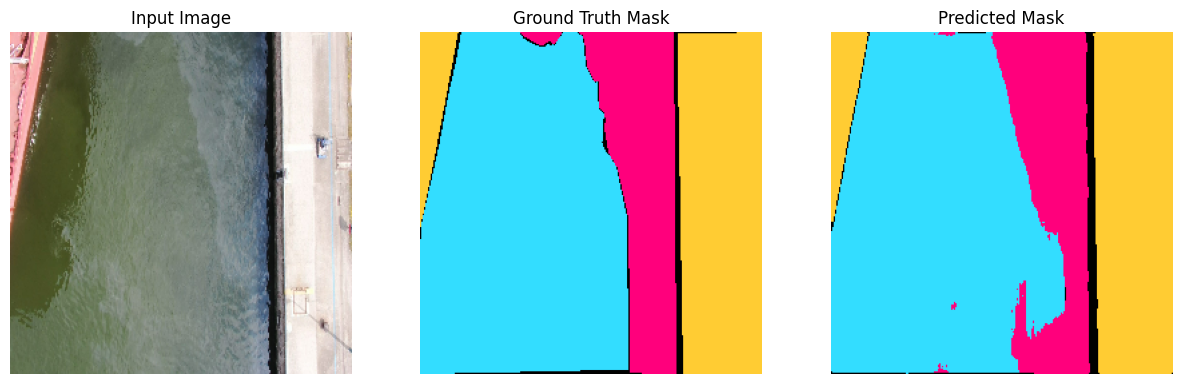

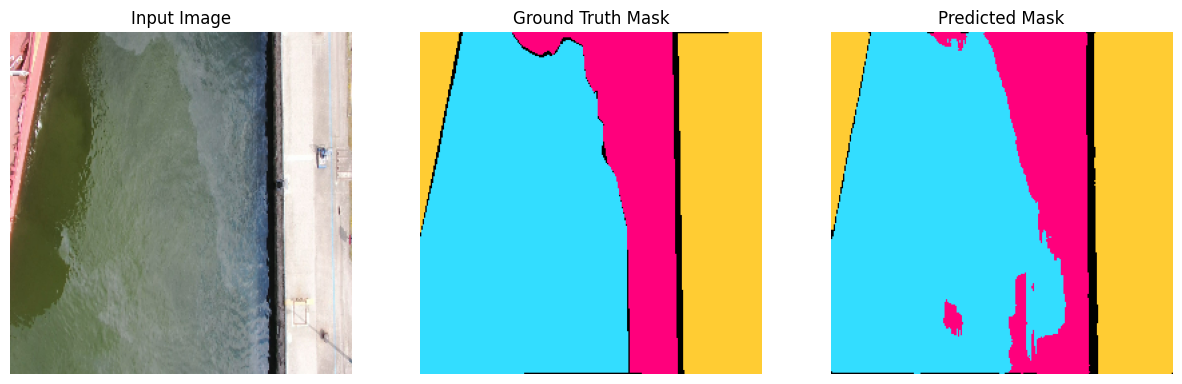

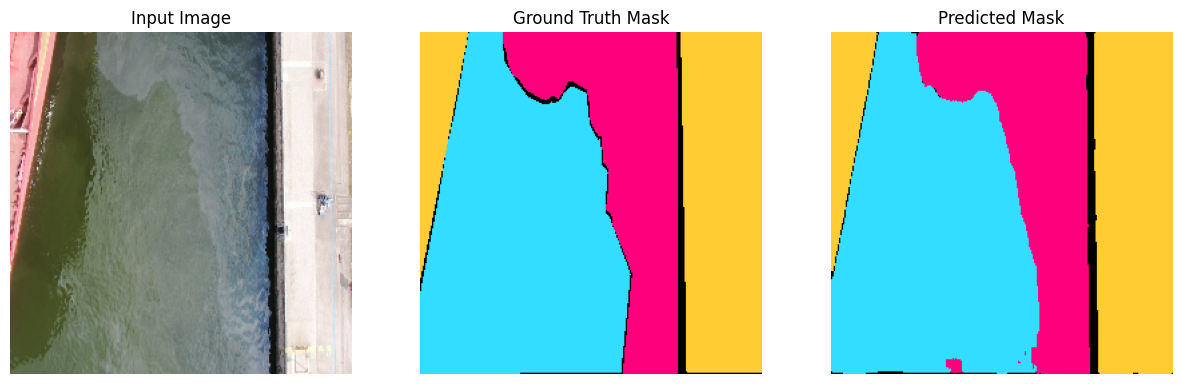

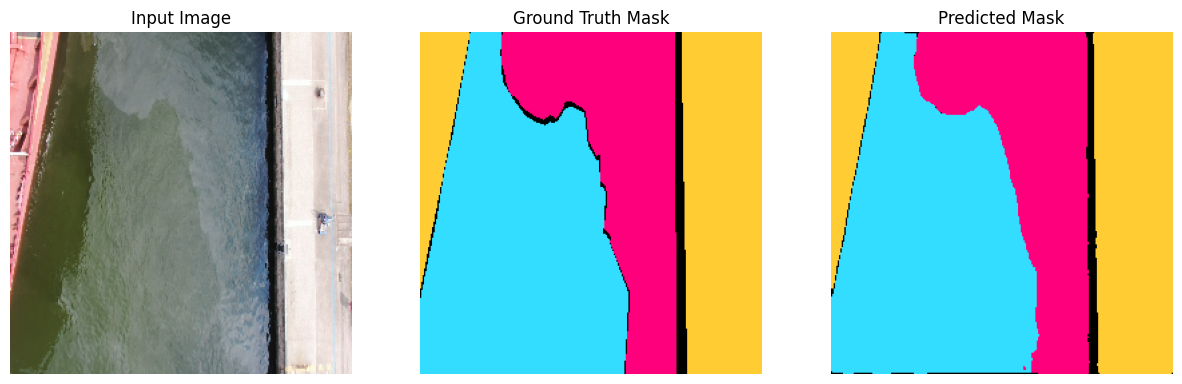

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


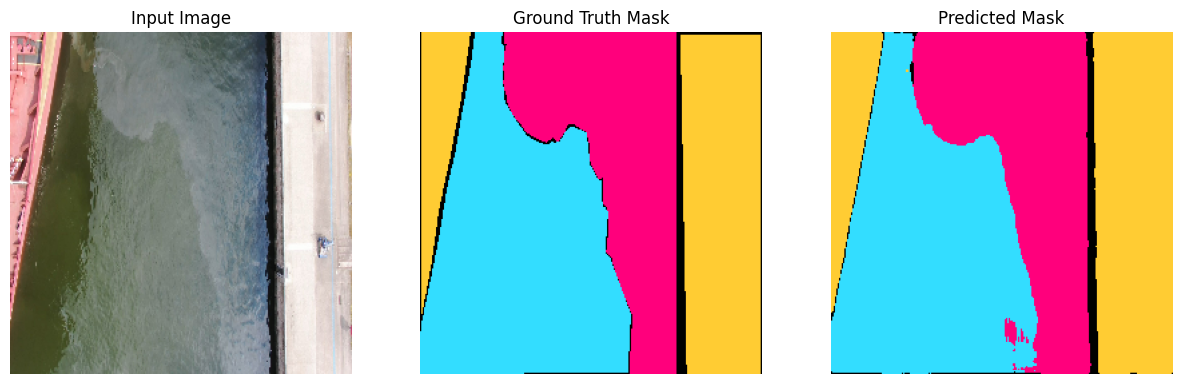

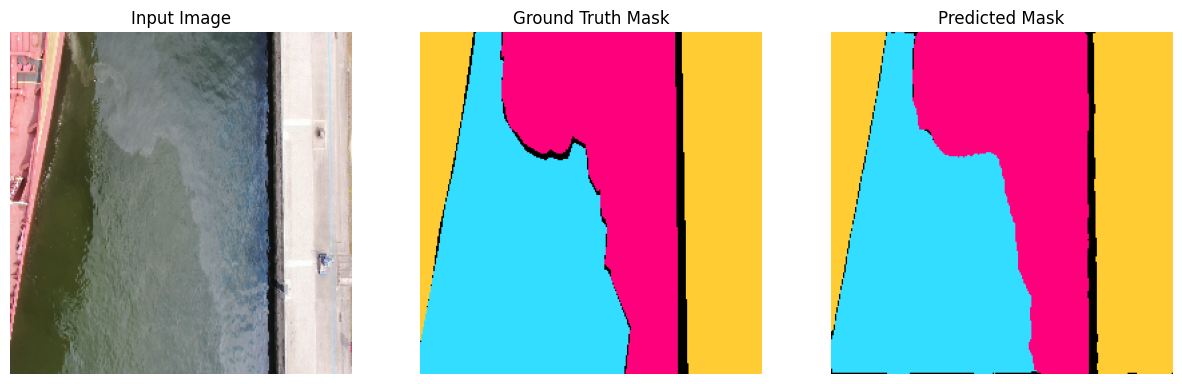

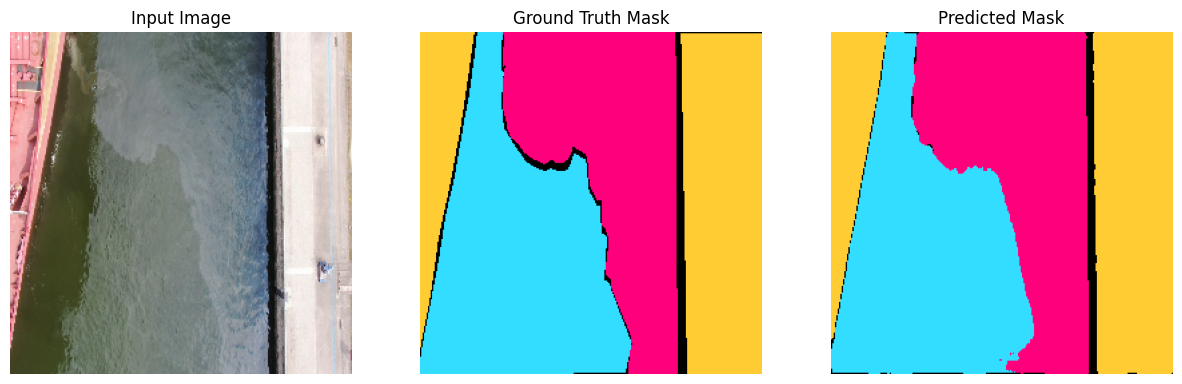

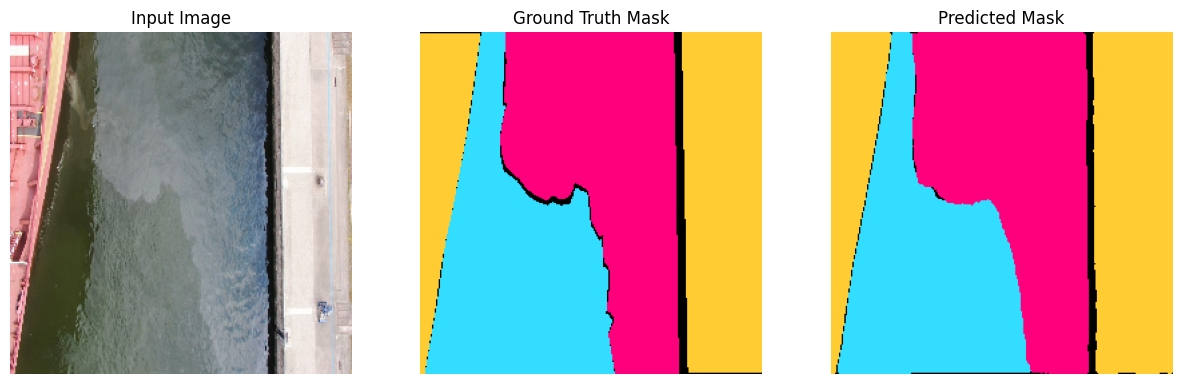

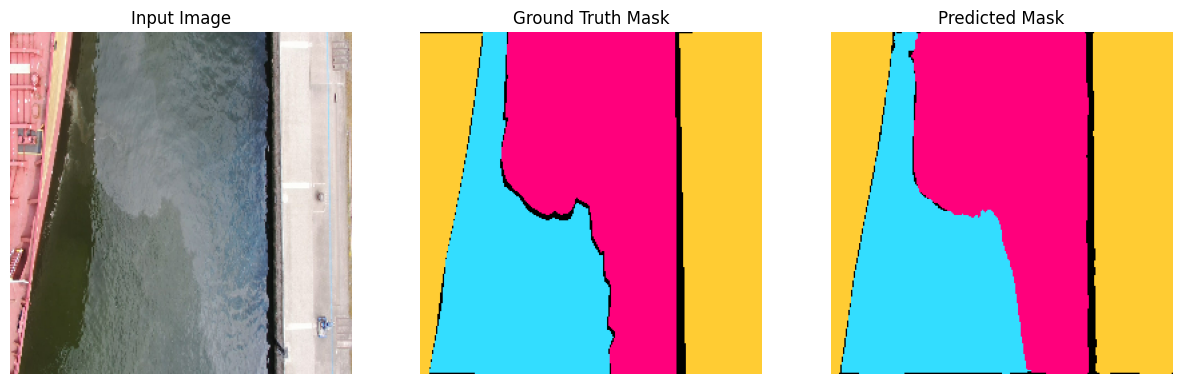

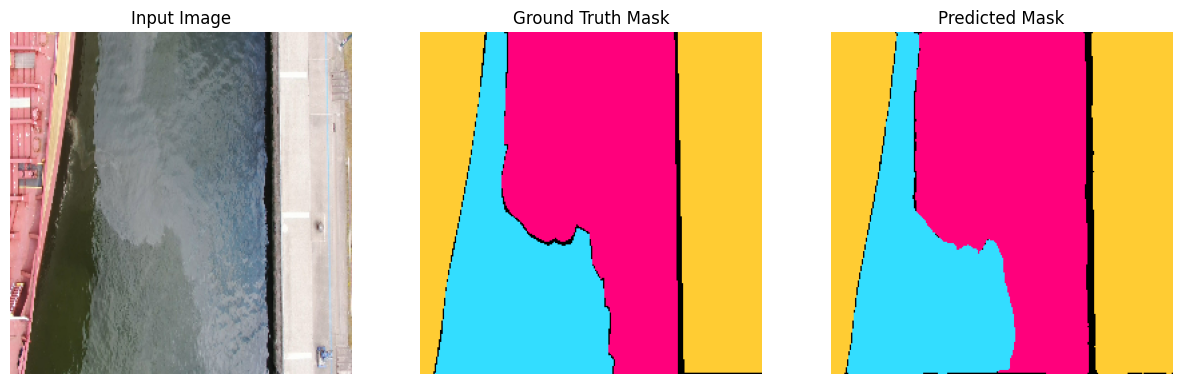

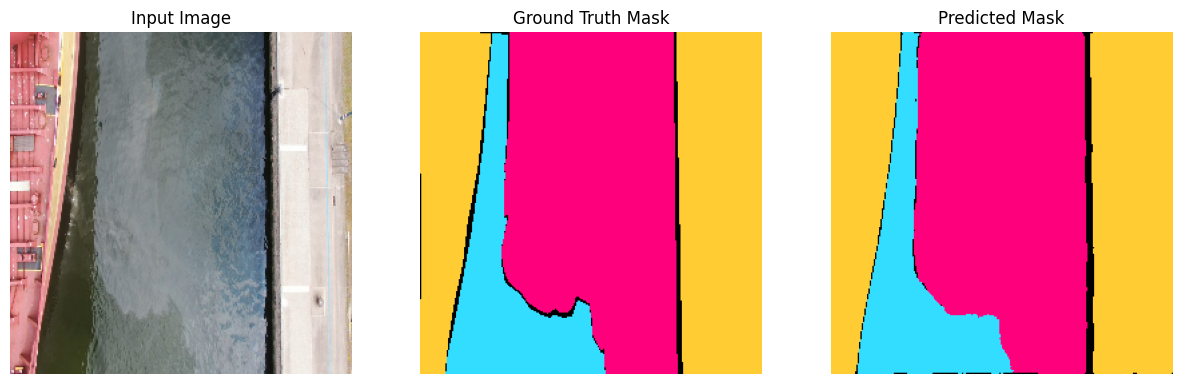

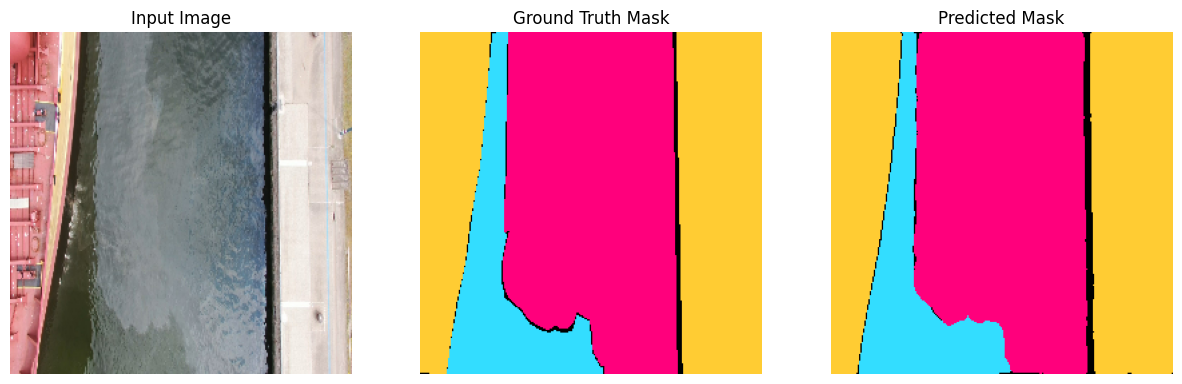

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


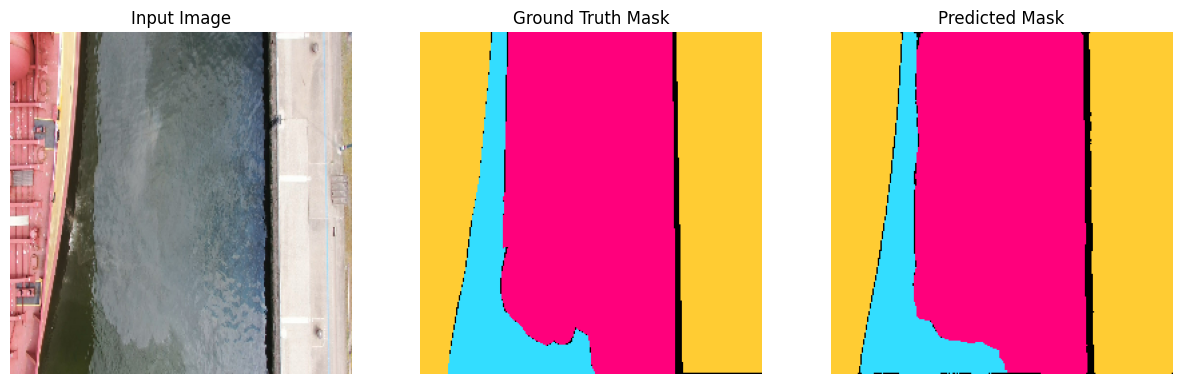

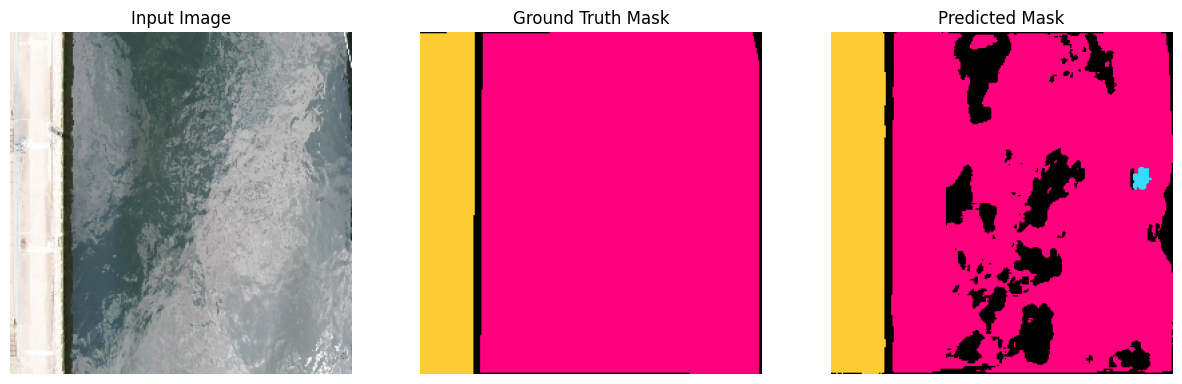

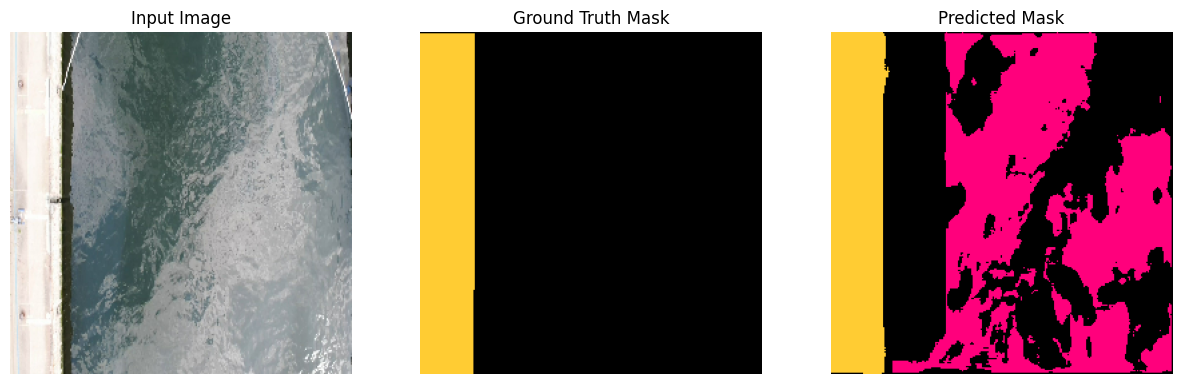

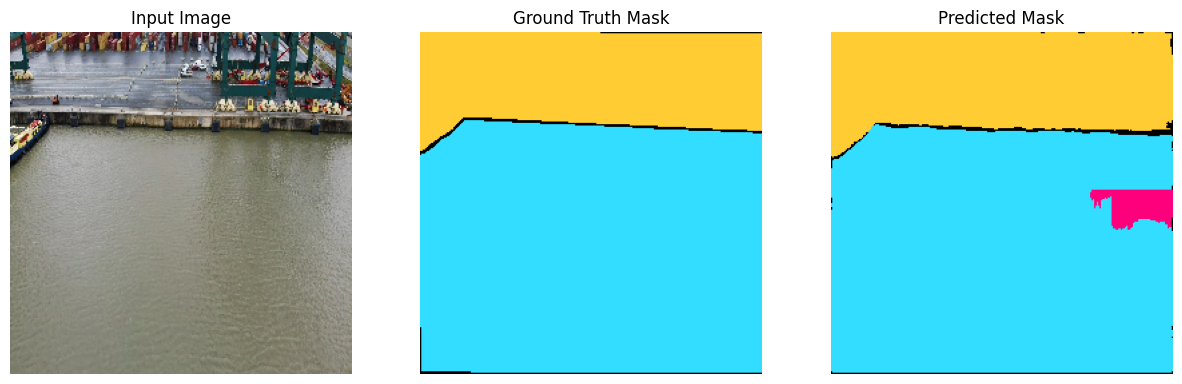

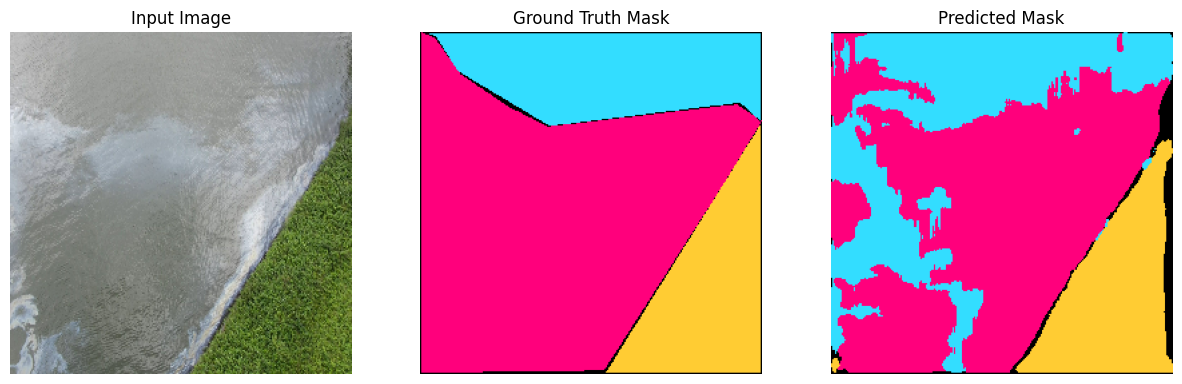

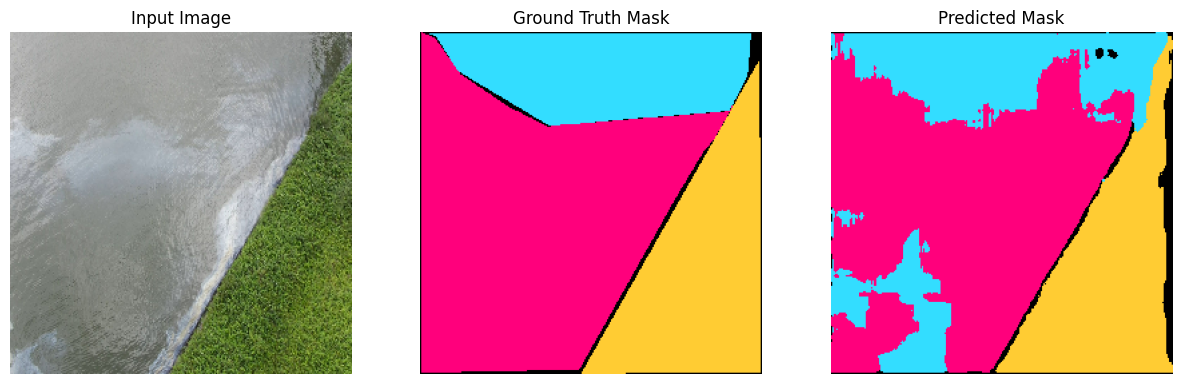

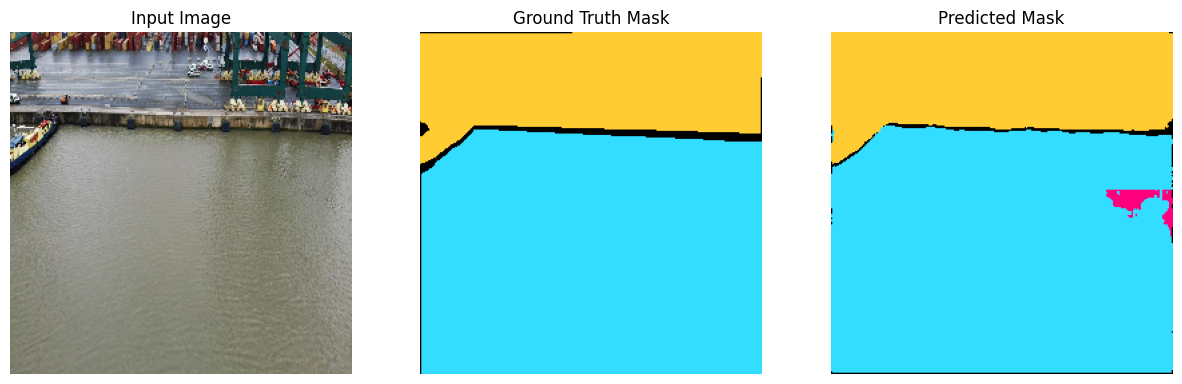

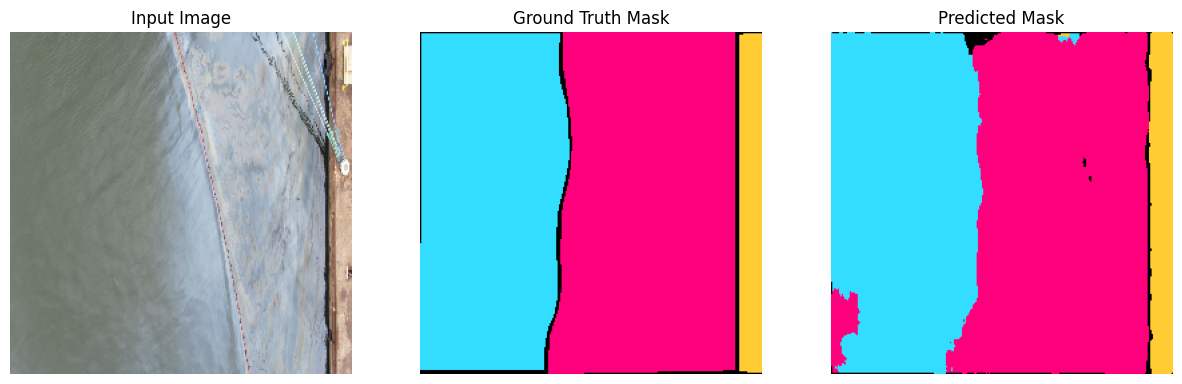

2025-07-25 18:03:13.037799: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
import matplotlib.pyplot as plt
import numpy as np

test_img_dir = os.path.expanduser('~/data/dataset/test/images')
test_masks_dir = os.path.expanduser('~/data/dataset/test/masks')
test_ds = create_dataset(test_img_dir, test_masks_dir, shuffle=False)

# Color map as a list for indexing by class id
CLASS_TO_RGB = [
    (0, 0, 0),           # 0 background
    (255, 0, 124),       # 1 oil
    (255, 204, 51),      # 2 others
    (51, 221, 255)       # 3 water
]

def class_to_rgb(mask):
    """
    Convert a (H,W) class id mask to an RGB mask (H,W,3)
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for cls_id, color in enumerate(CLASS_TO_RGB):
        rgb_mask[mask == cls_id] = color

    return rgb_mask

def display_predictions_with_colors(dataset, model, num=5):
    count = 0

    for images, masks in dataset.take(num):
        preds = model.predict(images)
        preds_classes = np.argmax(preds, axis=-1)

        images = images.numpy()
        masks_classes = np.argmax(masks.numpy(), axis=-1)

        batch_size = images.shape[0]

        for i in range(batch_size):
            plt.figure(figsize=(15,5))

            plt.subplot(1,3,1)
            plt.title('Input Image')
            plt.imshow(images[i])
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title('Ground Truth Mask')
            plt.imshow(class_to_rgb(masks_classes[i]))
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title('Predicted Mask')
            plt.imshow(class_to_rgb(preds_classes[i]))
            plt.axis('off')

            plt.savefig(f"./images/plot{count}.png")
            count += 1
            plt.show()

display_predictions_with_colors(test_ds, model, num=3)